In [7]:
import os

In [11]:
# step = 60000
versions = ['cc_merged_v2_8k', 'intramask_cc_8k', 'intramask_cc_merged_v2_8k', 'adamask_cc_merged_v2_8k', 'cc_merged_v2_8k_intrav2cont','cc_8k',]
step = 65000
# versions = ['cc_merged_v2_8k', 'intramask_cc_8k', 'intramask_cc_merged_v2_8k', 'adamask_cc_merged_v2_8k', 'cc_merged_v2_8k_intracccont','cc_8k',]

for model_name in versions:
    path = f"/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_360M_8k_{model_name}/iter-{step*4}-ckpt-step-{step}.pth"
    # path = f"/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_8k_{model_name}/iter-{step*8}-ckpt-step-{step}.pth"
    if not os.path.exists(path):
        print(f"model {model_name} not found")
    elif os.path.exists(f"/home/aiops/zhuty/tinyllama/out/tiny_LLaMA_360M_8k_{model_name}/iter-{step*4}-ckpt-step-{step}_hf/config.json"):
        print(f"model {model_name} already converted")
    else:
        # print(f"bash convert_to_hf_general.sh /home/aiops/zhuty/tinyllama/out/tiny_LLaMA_360M_8k_intramask_cc_merged_v2_8k iter-160000-ckpt-step-40000")
        print(f"bash convert_to_hf_general.sh /home/aiops/zhuty/tinyllama/out/tiny_LLaMA_360M_8k_{model_name} iter-{step*4}-ckpt-step-{step}")
        # print(f"bash convert_to_hf_general.sh /home/aiops/zhuty/tinyllama/out/tiny_LLaMA_1b_8k_{model_name} iter-{step*8}-ckpt-step-{step}")

model cc_merged_v2_8k not found
bash convert_to_hf_general.sh /home/aiops/zhuty/tinyllama/out/tiny_LLaMA_360M_8k_intramask_cc_8k iter-260000-ckpt-step-65000
bash convert_to_hf_general.sh /home/aiops/zhuty/tinyllama/out/tiny_LLaMA_360M_8k_intramask_cc_merged_v2_8k iter-260000-ckpt-step-65000
bash convert_to_hf_general.sh /home/aiops/zhuty/tinyllama/out/tiny_LLaMA_360M_8k_adamask_cc_merged_v2_8k iter-260000-ckpt-step-65000
model cc_merged_v2_8k_intrav2cont already converted
model cc_8k not found


In [9]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_data(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    return pd.DataFrame(data, columns=['length', 'loss'])

def process_data(data, bin_size=1000):
    # Define bins
    max_length = data['length'].max()
    bins = range(0, max_length + bin_size, bin_size)
    labels = [f"{i}-{i + bin_size - 1}" for i in bins[:-1]]

    # Bin data
    data['bin'] = pd.cut(data['length'], bins=bins, labels=labels, right=False)

    # Calculate statistics for loss
    stats_loss = data.groupby('bin')['loss'].agg(['mean', 'std'])

    # Calculate mean PPL
    data['ppl'] = np.exp(data['loss'])
    stats_ppl = data.groupby('bin')['ppl'].mean().rename('mean_ppl')

    # Combine results
    grouped = pd.concat([stats_loss, stats_ppl], axis=1).reset_index()
    return grouped

def plot_loss(all_grouped_data, model_names):
    plt.figure(figsize=(12, 6))
    for grouped_data, model_name in zip(all_grouped_data, model_names):
        plt.plot(grouped_data['bin'], grouped_data['mean'], label=model_name, marker='o', linestyle='-')  # Use a line plot
    plt.xlabel('Text Length')
    plt.ylabel('Average Loss')
    plt.title('Comparative Average Loss vs. Text Length')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

def plot_ppl(all_grouped_data, model_names):
    plt.figure(figsize=(12, 6))
    for grouped_data, model_name in zip(all_grouped_data, model_names):
        plt.plot(grouped_data['bin'], grouped_data['mean_ppl'], label=model_name, marker='o')
    plt.xlabel('Text Length')
    plt.ylabel('Average Perplexity')
    plt.title('Comparative Average Perplexity vs. Text Length')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
def main():
    # List of filepaths to your JSON files
    # versions = ['cc', 'cc_merged_v1', 'cc_merged_v2', 'cc_merged_v3', 'intramask_cc']
    # filepaths = [f'/home/aiops/zhuty/tinyllama/scripts/eval_ppl/results/tiny_LLaMA_1b_8k_{version}_8k_chunk_1000.json' for version in versions]
    versions = ['cc_merged_v2_', 'intramask_cc', 'intramask_cc_merged_v2', 'adamask_cc_merged_v2']
    versions = ['cc_merged_v2_8k', 'intramask_cc_8k', 'intramask_cc_merged_v2_8k', 'adamask_cc_merged_v2_8k', 'cc_merged_v2_8k_intrav2cont']
    # ds = '_arxiv'
    ds = '_rpwiki_en'
    # ds = '_'
    iter = "_iter-160000-ckpt-step-40000"
    filepaths = [f'/home/aiops/zhuty/tinyllama/scripts/eval_ppl/results/tiny_LLaMA_360M_8k_{version}_chunk_1000{ds}{iter}.json' for version in versions]

    # model_names = ['random','dense','bm25','gen+bm25', 'intramask']
    model_names = versions

    plt.figure(figsize=(12, 8))

    all_grouped_data = []
    for filepath in filepaths:
        data = load_data(filepath)
        print("file", filepath, "Average loss: ", data['loss'].mean())
        grouped_data = process_data(data)
        all_grouped_data.append(grouped_data)

    plot_loss(all_grouped_data, model_names)
    plot_ppl(all_grouped_data, model_names)

file /home/aiops/zhuty/tinyllama/scripts/eval_ppl/results/tiny_LLaMA_360M_8k_cc_merged_v2_8k_chunk_1000_rpwiki_en_iter-160000-ckpt-step-40000.json Average loss:  2.749256685144062
file /home/aiops/zhuty/tinyllama/scripts/eval_ppl/results/tiny_LLaMA_360M_8k_intramask_cc_8k_chunk_1000_rpwiki_en_iter-160000-ckpt-step-40000.json Average loss:  2.7267386506883153
file /home/aiops/zhuty/tinyllama/scripts/eval_ppl/results/tiny_LLaMA_360M_8k_intramask_cc_merged_v2_8k_chunk_1000_rpwiki_en_iter-160000-ckpt-step-40000.json Average loss:  2.7248671012712973
file /home/aiops/zhuty/tinyllama/scripts/eval_ppl/results/tiny_LLaMA_360M_8k_adamask_cc_merged_v2_8k_chunk_1000_rpwiki_en_iter-160000-ckpt-step-40000.json Average loss:  2.718822826802545
file /home/aiops/zhuty/tinyllama/scripts/eval_ppl/results/tiny_LLaMA_360M_8k_cc_merged_v2_8k_intrav2cont_chunk_1000_rpwiki_en_iter-160000-ckpt-step-40000.json Average loss:  2.7371518109167847


<Figure size 1200x800 with 0 Axes>

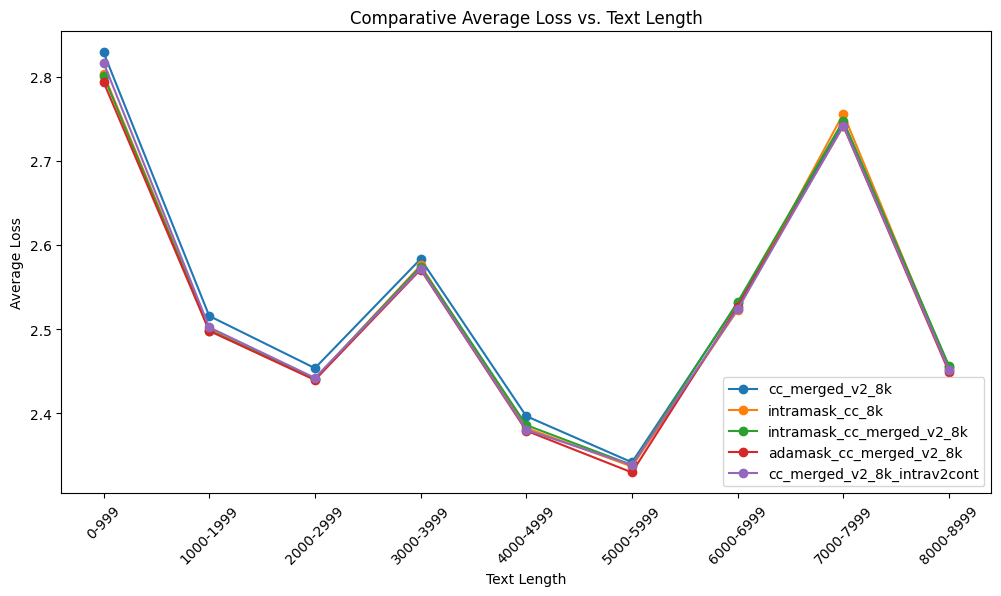

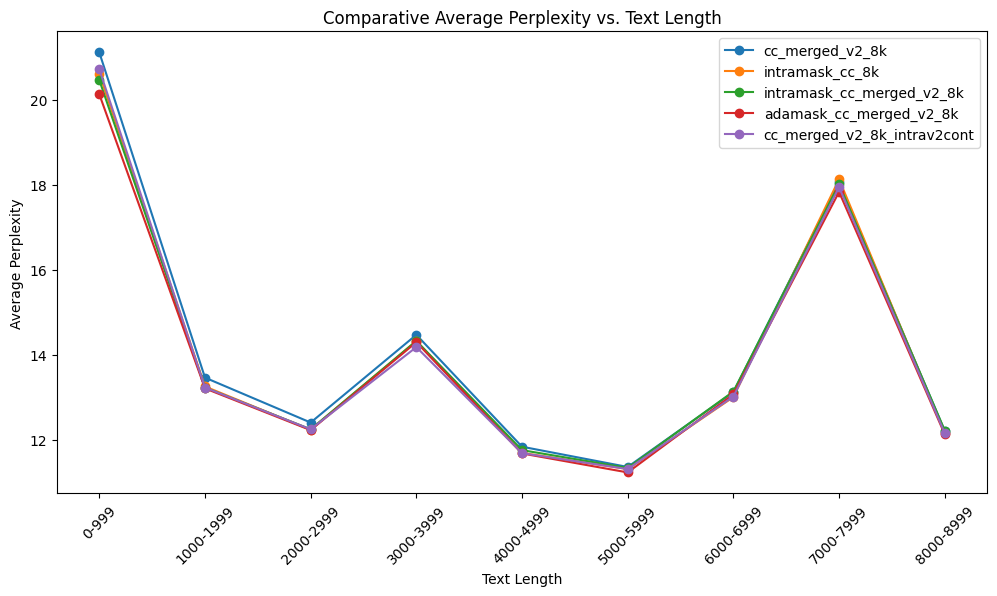

In [10]:
main()